In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np
from sklearn import preprocessing
import torch
from IPython import display

from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 12)

%load_ext autoreload
%autoreload 2

/home/icb/yang.an/miniconda3/envs/mvTCR_rep/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('../mvTCR')
import tcr_embedding.utils_training as utils
import config.constants_10x as const

from tcr_embedding.utils_preprocessing import stratified_group_shuffle_split, group_shuffle_split
from tcr_embedding.evaluation.Imputation import run_imputation_evaluation
from tcr_embedding.evaluation.Clustering import run_clustering_evaluation
from tcr_embedding.evaluation.kNN import run_knn_within_set_evaluation
from tcr_embedding.evaluation.WrapperFunctions import get_model_prediction_function

In [3]:
random_seed = 42
utils.fix_seeds(random_seed)

# Load and preprocess data

In [4]:
adata = sc.read_h5ad('../data/04_borch_annotated.h5ad')

metadata = ['Tissue', 'Type', 'Tissue+Type', 'Sample', 'functional.cluster', 'clonotype', 'set', 'Cohort']
adata.obs['Tissue+Type'] = [f'{tissue}.{type_}' for tissue, type_ in zip(adata.obs['Tissue'], adata.obs['Type'])]

In [5]:
holdout_cohorts = ['GSE154826',  # Lung with normal and tumor cells 18387 cells
                   'GSE162500',]  # Lung with 18850 cells


mapper = {'GSE123814': 0, 'GSE114724': 1, 'GSE139555': 2, 'GSE145370': 3,
          'GSE180268': 4, 'GSE176021': 5, 'GSE148190': 6, 'GSE159251': 7,
          'CCR-20-4394': 8, 'PRJNA705464': 9, 'GSE121636': 10, 'GSE154826': 11, 'GSE162500': 12}

adata.obs['Cohort_id'] = adata.obs['Cohort'].map(mapper)
adata.obsm['Cohort'] = torch.nn.functional.one_hot(torch.tensor(adata.obs['Cohort_id'])).numpy()

adata.obs['set'] = 'train'
adata.obs['set'][adata.obs['Cohort'].isin(holdout_cohorts)] = 'hold_out'

In [6]:
adata.obs['set'].value_counts()

train       685224
hold_out     37237
Name: set, dtype: int64

In [7]:
# Used to load model correctly
adata_train = adata[~adata.obs['Cohort'].isin(holdout_cohorts)].copy()
adata_train.obsm['Cohort'] = torch.nn.functional.one_hot(torch.tensor(adata_train.obs['Cohort_id'])).numpy()

adata_hold_out = adata[adata.obs['set'] == 'hold_out'].copy()
train, val = group_shuffle_split(adata_hold_out, group_col='clonotype', val_split=0.2, random_seed=random_seed)
adata_hold_out.obs['set'] = 'train'
adata_hold_out.obs.loc[val.obs.index, 'set'] = 'val'
adata_hold_out.obs['set'].value_counts()

train    29492
val       7745
Name: set, dtype: int64

# Load pretrained model and finetune on hold out dataset

In [8]:
# Load pretrained model for finetuning on hold_out dataset
model_moe = utils.load_model(adata_train, f'../saved_models/journal/borcherding/scarches/borcherding_moe_with_scarches.pt', base_path='')
model_moe.add_new_embeddings(2)
model_moe.freeze_all_weights_except_cond_embeddings()

# Get training parameters
model_file = torch.load(f'../saved_models/journal/borcherding/scarches/borcherding_moe_with_scarches.pt')
params_architecture = model_file['params_architecture']

# Change adata for finetuning
model_moe.change_adata(adata_hold_out)

params_architecture['loss_weights'][2] = 1e-6

model_moe.train(n_epochs=200, batch_size=params_architecture['batch_size'], learning_rate=params_architecture['learning_rate'], 
                loss_weights=params_architecture['loss_weights'], kl_annealing_epochs=None, early_stop=5, 
                save_path=f'../saved_models/finetuned/', comet=None)

  4%|█████▊                                                                                                                          | 9/200 [01:11<25:14,  7.93s/it]

Early stopped


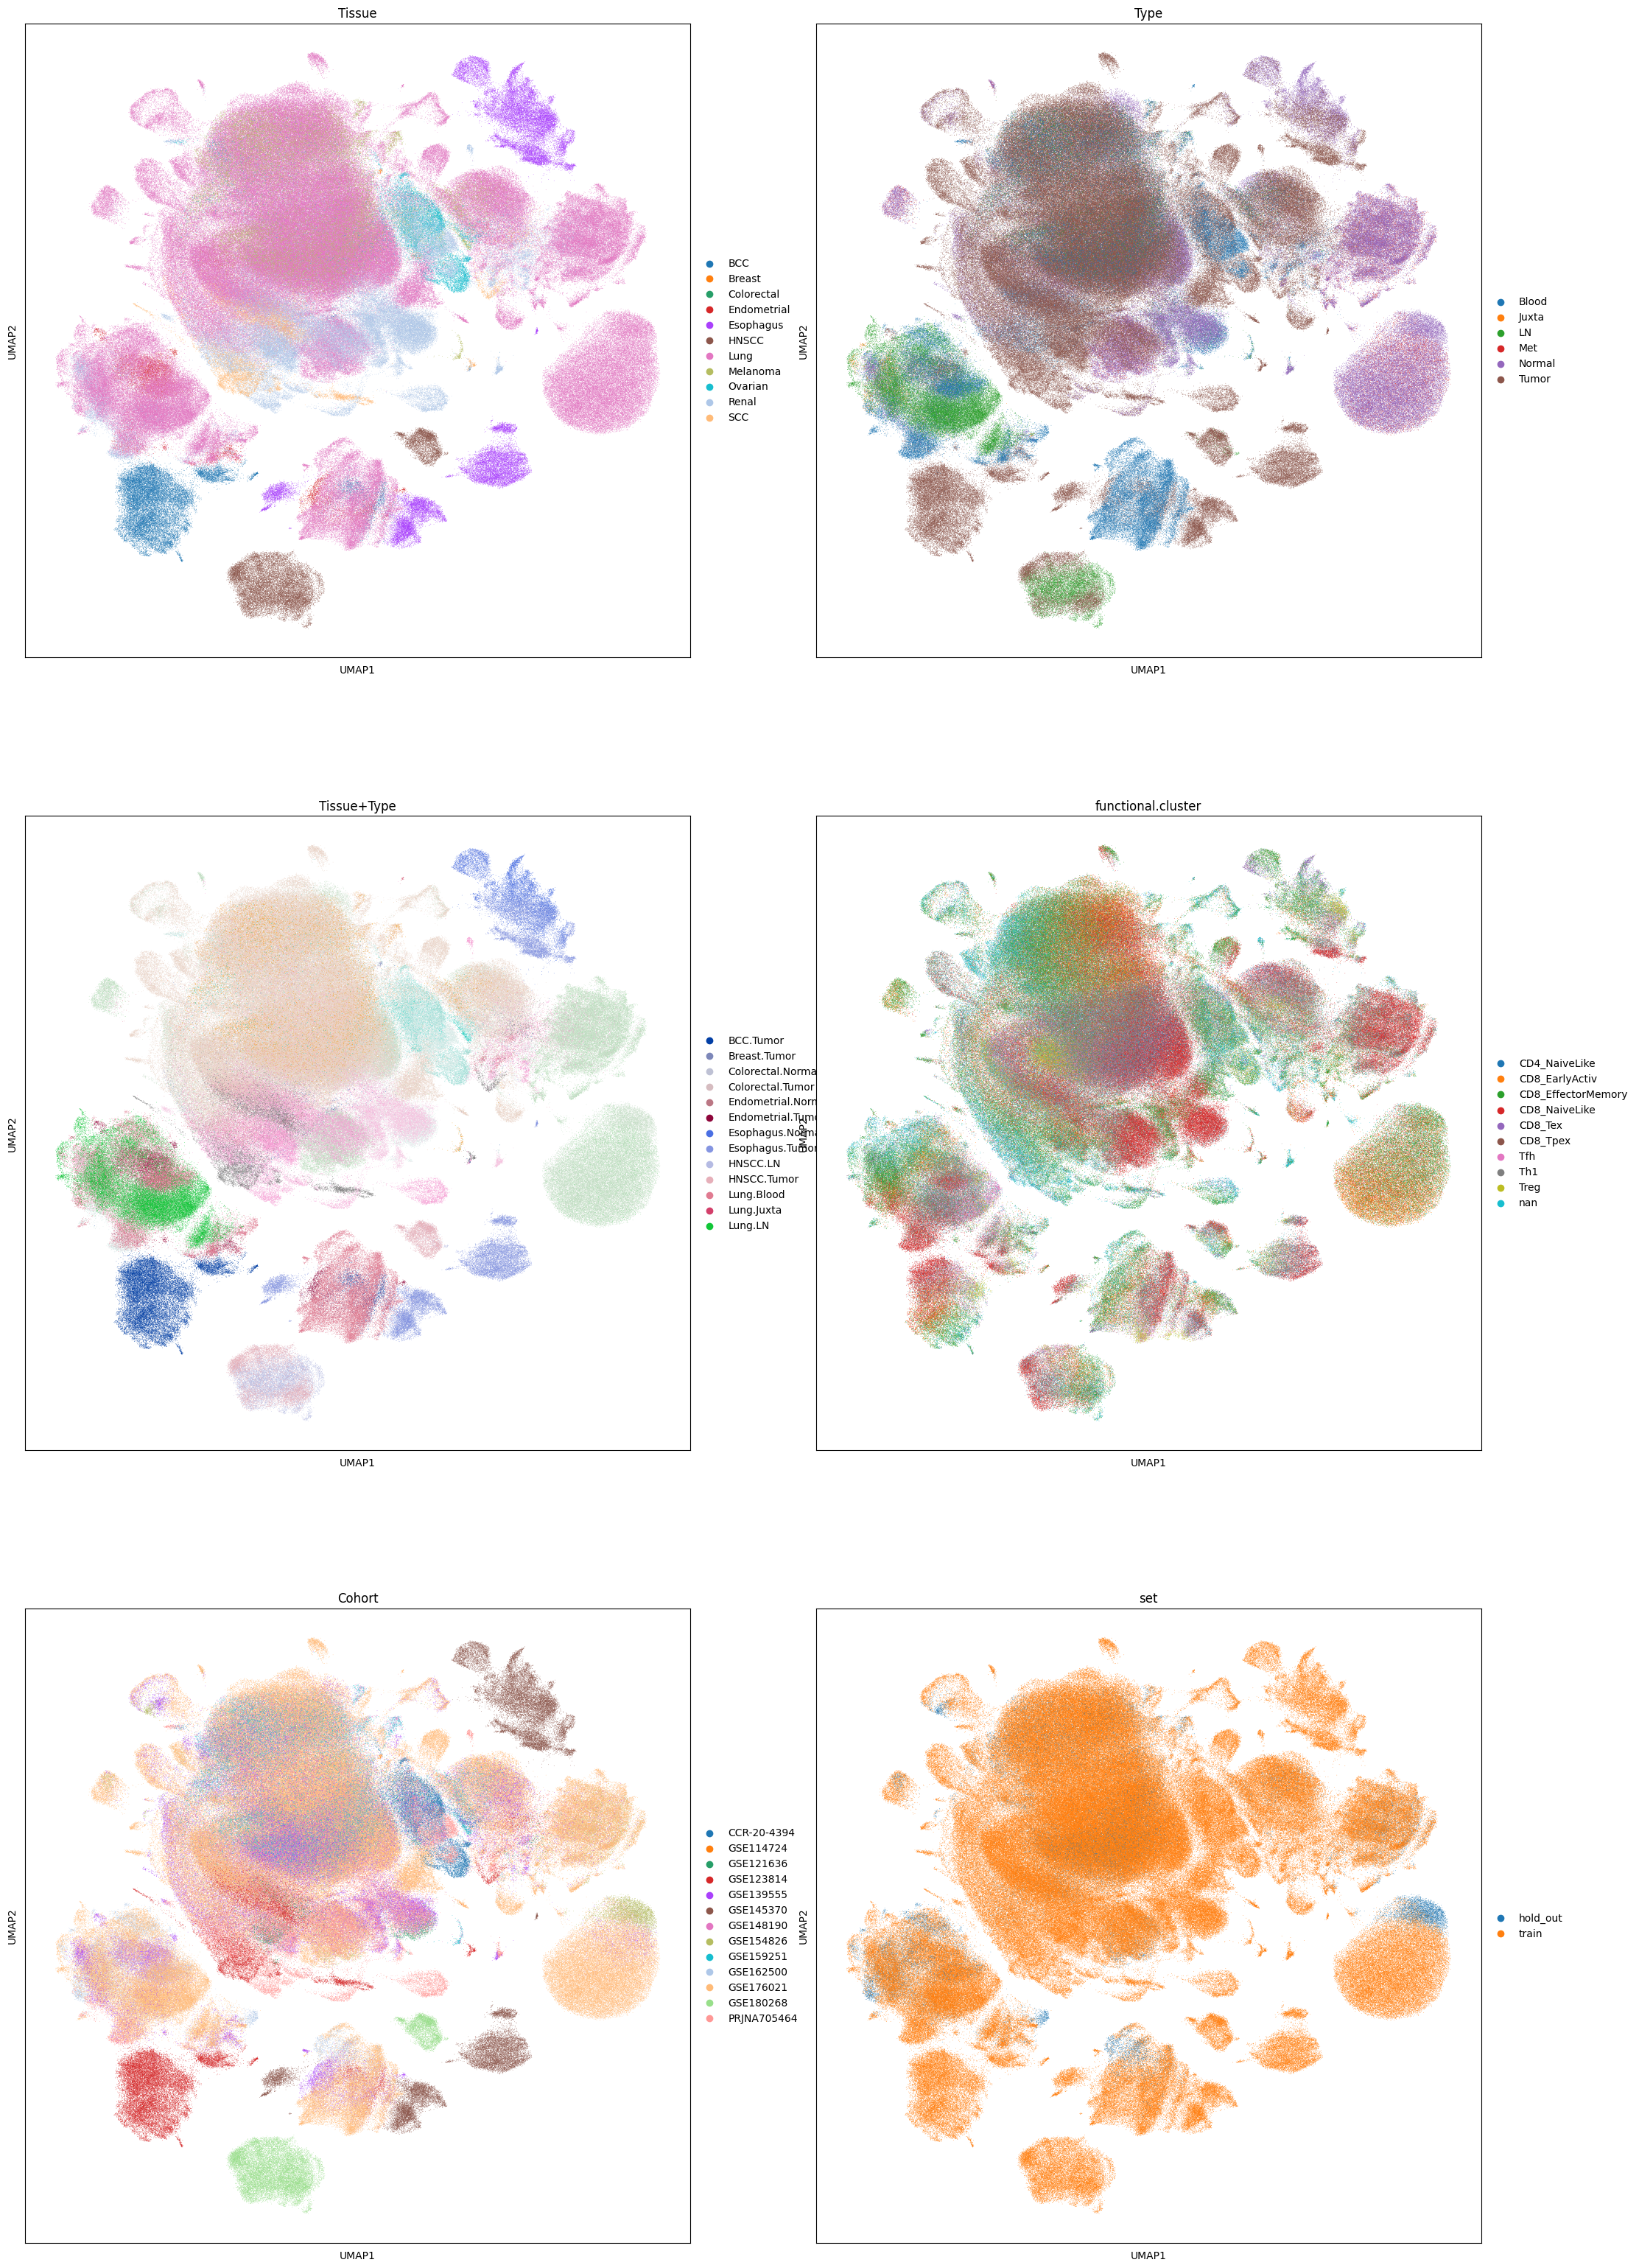

In [9]:
model_moe = utils.load_model(adata_hold_out, f'../saved_models/finetuned/best_model_by_metric.pt', base_path='')

latent_moe = model_moe.get_latent(adata, metadata=metadata, return_mean=True)
sc.pp.neighbors(latent_moe)
min_dist = 0.5
spread = 1.0
sc.tl.umap(latent_moe, min_dist=min_dist, spread=spread)
latent_moe.obsm[f'X_umap_min_dist_{min_dist}_spread_{spread}'] = latent_moe.obsm['X_umap'].copy()
sc.pl.umap(latent_moe, color=['Tissue', 'Type', 'Tissue+Type', 'functional.cluster', 'Cohort', 'set'], size=1, ncols=2)


In [10]:
latent_moe.write_h5ad('../data/borcherding_moe_scarches.h5ad', compression='gzip')